In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect

inspector = inspect(engine)

for i in inspector.get_columns("measurement"):
    print(i["name"],i["type"])

for j in inspector.get_columns("station"):
    print(j["name"],j["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute("SELECT * FROM Measurement limit 10").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
engine.execute("SELECT * FROM Station limit 10").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_day)
year_ago =  dt.date(2017,8,23)- dt.timedelta(365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date<= last_day).\
    filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns = ["date", "precipitation"])
prcp_df = prcp_df.set_index("date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()
prcp_df.head()

2017-08-23
2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

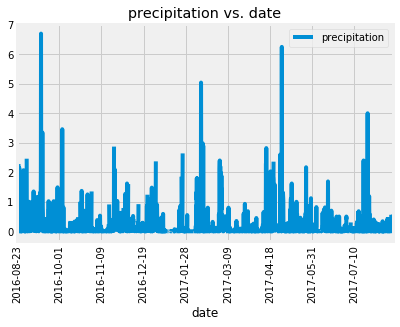

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title = "precipitation vs. date")
plt.xticks(rotation = 90)

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} stations available in this dataset")

There are 9 stations available in this dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stats = [func.min(Measurement.tobs),
                 func.max(Measurement.tobs),
                 func.avg(Measurement.tobs)]
active_station_temp = session.query(*stats).\
    filter(Measurement.station == active_stations[0][0]).all()
active_station_temp

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_temp = session.query(Measurement.tobs).\
    filter(Measurement.date<=last_day).filter(Measurement.date>=year_ago).\
    filter(Measurement.station == active_stations[0][0]).all()   

In [20]:
active_station_temp_df = pd.DataFrame(active_station_temp)
active_station_temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


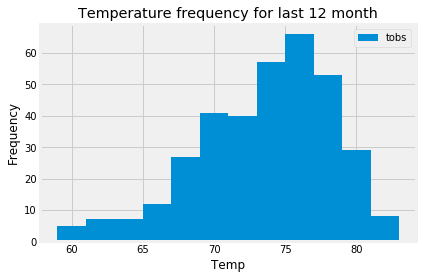

In [21]:
plt.hist(active_station_temp_df["tobs"],bins=12, label = "tobs")
plt.title("Temperature frequency for last 12 month")
plt.ylabel("Frequency")
plt.xlabel("Temp")
plt.legend()

## Optional: Other Recommended Analysis

### Temperature Analysis I

In [124]:
#Import measurement ans station dataframes
measurement_df = pd.read_csv("Resources/hawaii_measurements.csv")
station_df = pd.read_csv("Resources/hawaii_stations.csv")
print(measurement_df.head())
print(station_df.head())

       station        date  prcp  tobs
0  USC00519397  2010-01-01  0.08    65
1  USC00519397  2010-01-02  0.00    63
2  USC00519397  2010-01-03  0.00    74
3  USC00519397  2010-01-04  0.00    76
4  USC00519397  2010-01-06   NaN    73
       station                                    name  latitude  longitude  \
0  USC00519397                    WAIKIKI 717.2, HI US   21.2716  -157.8168   
1  USC00513117                    KANEOHE 838.1, HI US   21.4234  -157.8015   
2  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213  -157.8374   
3  USC00517948                       PEARL CITY, HI US   21.3934  -157.9751   
4  USC00518838              UPPER WAHIAWA 874.3, HI US   21.4992  -158.0111   

   elevation  
0        3.0  
1       14.6  
2        7.0  
3       11.9  
4      306.6  


In [135]:
#June temperature
june_df = measurement_df[pd.to_datetime(measurement_df["date"]).dt.month == 6]
june_df.head()

,station,date,prcp,tobs
133,USC00519397,2010-06-01,0.00,78
134,USC00519397,2010-06-02,0.01,76
135,USC00519397,2010-06-03,0.00,78
136,USC00519397,2010-06-04,0.00,76
137,USC00519397,2010-06-05,0.00,77


In [138]:
#Average temp for June
june_ave = june_df["tobs"].mean()
june_ave

74.94411764705882

In [137]:
#December temperature
dec_df = measurement_df[pd.to_datetime(measurement_df["date"]).dt.month == 12]
dec_df.head()

,station,date,prcp,tobs
305,USC00519397,2010-12-01,0.04,76
306,USC00519397,2010-12-03,0.00,74
307,USC00519397,2010-12-04,0.00,74
308,USC00519397,2010-12-06,0.00,64
309,USC00519397,2010-12-07,0.00,64


In [139]:
#Average temp for December
dec_ave = dec_df["tobs"].mean()
dec_ave

71.04152933421226

#### t-test
A paired t-test should be used since we are comparing the means of the same group at different time

In [141]:
from scipy.stats import ttest_rel

### Temperature Analysis II

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
def start(date):
    # Create our session (link) from Python to the DB

    """Return a list of all percipitation"""
    # Query all passengers

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    results = session.query(*sel).filter(Measurement.date >= date).all()
    

    # Convert list of tuples into normal list
    startonly = list(np.ravel(results))

    return startonly
start("2017-01-01")

[58.0, 74.14387974230493, 87.0]

In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.datetime(2018,3,1)
end_date = dt.datetime(2018,3,5)
steps = dt.timedelta(365)
print(calc_temps(start_date-steps, end_date-steps))

[(68.0, 72.9090909090909, 78.0)]


Text(0, 0.5, 'Temp(F)')

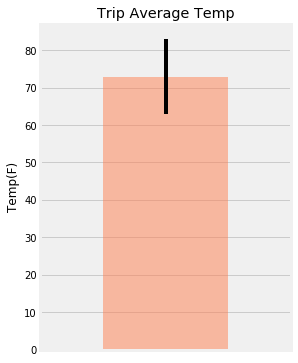

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tstats = calc_temps(start_date-steps, end_date-steps)
tstats_df = pd.DataFrame(tstats, columns = ["min", "ave", "max"])
ave_df = tstats_df["ave"]

plt.figure(figsize = (4,6))
ave_df.plot.bar(yerr = tstats_df["max"]-tstats_df["min"], title = "Trip Average Temp",
               alpha = 0.5, color = "coral")
plt.xticks([])
plt.ylabel("Temp(F)")

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
    filter(Measurement.date<= "2017-03-05").filter(Measurement.date>= "2017-03-01").\
    group_by(Station.station).order_by(Measurement.prcp.desc()).all()
rainfall

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

### Daily Rainfall Average

In [14]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [70]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = dt.date(2018,1,1)
end_date = dt.date(2018,1,5)
step = dt.timedelta(365)

# Use the start and end date to create a range of dates
dates = pd.date_range(start_date-step, end_date-step)

# Stip off the year and save a list of %m-%d strings
dates = dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normal = []
for i in dates:
    trip_normal.extend(daily_normals(i))
trip_normal

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0)]

In [114]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normal_df = pd.DataFrame(trip_normal, columns = ["tmin", "tave", "tmax"],
                             index = pd.date_range("2018-01-01","2018-01-05").strftime("%Y-%m-%d"))

trip_normal_df

,tmin,tave,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


Text(0.5, 0, 'Dates')

<Figure size 864x576 with 0 Axes>

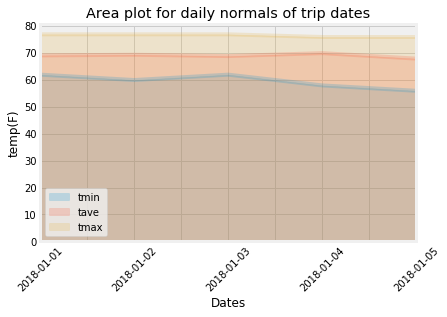

In [119]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize = (12,8))
trip_normal_df.plot.area(stacked = False, alpha = 0.2)
plt.xticks(rotation = 45)
plt.title("Area plot for daily normals of trip dates")
plt.ylabel("temp(F)")
plt.xlabel("Dates")